<h1 align="center">NER em Português</h1>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Link de estudo:

* [NER em Português](https://github.com/gdutramartins/po-ner-2-portuguese-ner)

# Instalação e import de algumas bibliotecas 

```
!pip install transformers
!pip install ipymarkup
```

In [1]:
from typing import Dict, List, Tuple, Union
import re
import json
from dataclasses import dataclass
import itertools

import pandas as pd

import os
import gc
from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizerFast, DistilBertTokenizerFast, BatchEncoding, PreTrainedTokenizerFast, TrainingArguments, Trainer
from transformers import BertForTokenClassification, DistilBertForTokenClassification
from tokenizers import Encoding

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from ipymarkup import show_box_markup
from ipymarkup import show_line_markup
from ipymarkup.palette import palette, BLUE, RED, GREEN, BROWN, GREY, ORANGE

import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import numpy

/home/tesla/Eddy_Giusepe_Deep_Learning/NLP_Transformers/venv_transformers/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Funções gerais

In [2]:
# Liberar e monitorar memória da GPU
def destroy_model(model: Union[DistilBertForTokenClassification,BertForTokenClassification]):
    del model
    gc.collect()
    torch.cuda.empty_cache()

def destroy_tokenizer(tokenizer: Union[BertTokenizerFast, DistilBertTokenizerFast]):
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()

def get_gpu_memory_status():
    total = (torch.cuda.get_device_properties(0).total_memory)/(1024 **2)
    reserved = (torch.cuda.memory_reserved(0))/(1024 **2)
    allocated = (torch.cuda.memory_allocated(0))/(1024 **2)
    return f"Total: {total:.2f} | Reserved: {reserved:.2f} | Allocated: {allocated:.2f}"

In [3]:
def plot_grafico_trainer_loss(trainer_loss: numpy.ndarray, validation_loss: numpy.ndarray):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(trainer_loss[:,0],trainer_loss[:,1] , label="training loss")
    plt.plot(validation_loss[:,0], validation_loss[:,1] , label="validation loss")

    # Label the plot.
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()
    
    

# Constantes

In [4]:
GDRIVE_PATH:str = '/home/tesla/Eddy_Giusepe_Deep_Learning/NLP_Transformers/NER_BERT_Deep_Learning/Dataset_HAREM_processamento/dataset'
DATASET_PRIMEIRO_HAREM = os.path.join(GDRIVE_PATH, 'CDPrimeiroHAREMprimeiroevento.json')
DATASET_MINI_HAREM = os.path.join(GDRIVE_PATH, 'CDPrimeiroHAREMMiniHAREM.json')    
DATASET_SEGUNDO_HAREM = os.path.join(GDRIVE_PATH, 'CDSegundoHAREMReRelEM.json')    
DATASETS_HAREM=[DATASET_PRIMEIRO_HAREM, DATASET_MINI_HAREM, DATASET_SEGUNDO_HAREM]

LABEL_LIST = [
    'PESSOA',
    'ORGANIZACAO',
    'LOCAL',
    'TEMPO',
    'VALOR',
]

SEPARADOR_SENTENCA = ['.', '?', '!']
PUNCTUATION_LIST = [ ',','.',':',';']
CONTROL_TOKENS = ['[PAD]', '[SEP]', '[CLS]' ]

MODEL_BASE: str = 'neuralmind/bert-base-portuguese-cased'
MODEL_TRAINED_PATH: str = os.path.join(GDRIVE_PATH, 'portuguese-ner')
MODEL_TRAINED_LOG: str = os.path.join(MODEL_TRAINED_PATH, 'trainer.log')
LABEL_OUTPUT_PATH: str = os.path.join(MODEL_TRAINED_PATH, 'labelset.txt')

# Classes

In [5]:
#------------------------------------------------------------------------------#
class Anotacao:
    """
        Representa uma anotação de entidade, contendo o texto, label e span(inicio, fim).
    """ 
    def __init__(self):
        self.text: str = ''
        self.label: str = ''
        self.start_offset: int = 0
        self.end_offset: int = 0

    def __str__(self):
        return f"{self.text} - ({self.label}) - {self.start_offset}:{self.end_offset} \n"

    def __repr__(self):
        return self.__str__()

    def copy_from(self, origem) -> None:
        """ 
            Args:
                origem(Anotacao):
                    copia os dados da anotação origem
            Returns:
                None
        """
        self.text = origem.text
        self.label = origem.label
        self.start_offset = origem.start_offset
        self.end_offset = origem.end_offset

#------------------------------------------------------------------------------#
class Document:
    """
        Representa um documento e suas entidades associadas, identificadas por Anotações.
        Contém também uma representação estatística para montagem dos Data Frames
    """

    def __init__(self):
        self.text: str = None
        self.lista_anotacao: List[Anotacao] = []
        self.numero_palavras: int = 0
        self.numero_ent_label: Dict[str, int] = {}
        
        for label in LABEL_LIST:
            self.numero_ent_label[label] = 0
    
    def __str__(self):
            return f"{self.text[0:30]}... Anotacoes({len(self.lista_anotacao)}) Palavras({self.numero_palavras}) Quantidades({self.numero_ent_label})"

    def __repr__(self):
        return self.__str__()
    
    def adiciona_anotacao(self, anotacao: Anotacao) -> None:
        self.lista_anotacao.append(anotacao)
        self.__incrementa_label(anotacao.label)

    def __incrementa_label(self, label) -> None:
        self.numero_ent_label[label] += 1
    
    def conta_palavras(self) -> None:
        self.numero_palavras = len(self.text.split())
    
    def to_dict(self) -> Dict[str,int]: 
        return {
            'text': self.text,
            'numero_palavras': self.numero_palavras,
            'QTD_PESSOA' : self.numero_ent_label['PESSOA'],
            'QTD_ORGANIZACAO': self.numero_ent_label['ORGANIZACAO'],
            'QTD_LOCAL' : self.numero_ent_label['LOCAL'],
            'QTD_TEMPO' : self.numero_ent_label['TEMPO'],
            'QTD_VALOR' : self.numero_ent_label['VALOR']
        }

In [6]:
@dataclass
class TrainingBatchExample:
    batch_encoding: BatchEncoding
    labels: List[List[int]]

In [7]:
class NERDataset(torch.utils.data.Dataset):
    """
        Subclasse do Dataset Torch utilizada para abstrair a complexidade dos itens informados ao modelo
        durante o treino, validação e teste.
    """
    def __init__(self, batch: Union[BatchEncoding, TrainingBatchExample], labels: List[List[int]]=None):
        _batch_encodings: BatchEncoding = None
        _labels: List[List[int]] = []

        if isinstance(batch, TrainingBatchExample):
            _batch_encodings = batch.batch_encoding
            _labels = batch.labels
        else:
            _batch_encodings = batch
            _labels = labels

        if ("offset_mapping" in _batch_encodings):
            batch_encoding.pop("offset_mapping")
        self.batch_encodings = _batch_encodings
        self.labels = _labels        

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.batch_encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        if self.labels is not None:
            return len(self.labels)
        else:
            return len(self.batch_encodings.encodings)

In [8]:
class LabelNER:
    """
        Classe preparada que contém os labels de um treinamento e teste supervisionado de NER.
        Essa versão do LabelNer trata somente labels com span's, ou seja, a lista de inicialização não contém prefixos e o O(utside) 

        load_from_list e load_from_annotations devem ser utilizados no treinamento.
        Ao terminar o treinamento salvar um cópia com o método save().
        No caso de predição ou carga para teste utilizar o load_from_file() para carregar um label set com a mesma ordem utilizada no treino.
     
    """

    def __str__(self):
            return f"{len(self.labels_to_id)} labels {str(self.labels_to_id)}"

    def __repr__(self):
        return self.__str__()

    def __len__(self):
        return len(self.labels_to_id)

    def __init__(self):
        self.labels_to_id = {}
        self.ids_to_label = {}
        
    def get_label_list(self):
        return self.labels_to_id.keys()

    def get_id_list(self):
        return self.ids_to_label.keys()

    def load_from_simple_list(self, labels: List[str]) -> None:
        '''
            Args: 
                labels(:obj:`List[str]`):
                    Lista de labels sem prefixo e não contendo o tipo O(utside).
            
            Inclui o tipo O(utside) e faz a permutação entre labels e os prefixos do formato informado
        '''
        self.labels_to_id["O"] = 0
        self.ids_to_label[0] = "O"
        num = 0  # in case there are no labels
        prefix_list: str = "BI" 
        for _num, (label, s) in enumerate(itertools.product(labels, prefix_list)):
            num = _num + 1  # skip 0
            l = f"{s}-{label}"
            self.labels_to_id[l] = num
            self.ids_to_label[num] = l
        
     
    def load_from_file(self, input_file_path:str) -> None:
        '''
            Carrega o arquivo com os labels ordenados. O arquivo pode ser construido manualmente, mas deve conter um label por linha, na ordem utilizada para treinar o modelo, já que essa ordem foi criada na 
            extração ou carga dos labels para o treinamento do modelo.

            Args: 
                labelset_file(:obj:`str`):
                    Nome do arquivo contendo a lista de labels previamente gravado. Muito importante ter sido gravado por essa classe ou ter a garantia que o arquivo está com os labels na ordem correta.           
        '''
        with open(input_file_path, 'r' ) as label_file:
            for ind, label in enumerate(label_file):
                label = label.strip('\n')
                self.labels_to_id[label] = ind
                self.ids_to_label[ind] = label

    def save(self, output_file_path: str):
        with open(output_file_path, 'w' ) as label_file:
            for label in self.labels_to_id:
                label_file.write(label)
                label_file.write('\n')    


    def convert_label_list_to_id_list(self, lista: List[str]) -> List[int]:
        """
            Converte uma lista de labels nos respectivos id`s. Para processamento no modelo essa conversão precisará ser realizada
        """
        return list(map(self.labels_to_id.get, lista))

    def convert_id_list_to_label_list(self, lista: List[int]) -> List[str]:
        """
            Converte uma lista de id`s nos respectivos labels. Para compreensão do resultado retornado pelo modelo essa conversão será necessária.
        """
        return list(map(self.ids_to_label.get, lista))  

# Carregando os Datasets

In [9]:
def carrega_dataset_harem(file_name:str) -> List[Document]:
    """
        Carrega o dataset Harem no formato JSON.
        O formato origem do Harem é XML, mas convertemos para JSON em etapa anterior.
        Formato esperado:
        [
            {
                doc_id: str
                doc_text: str
                entities: [{
                    entity_id: str
                    text: str
                    start_offset: int
                    end_offset: int
                }]
            }
        ]
        
        Args:
            file_name(str):
                nome do arquivo que será carregado

        Returns:
            List[Document]:
                retorna a lista de documentos e suas anotações

    """ 

    doc_list: List[Document] =[]

    with open(file_name) as json_ds_file:
        raw = json.load(json_ds_file)
        for example in raw:
            doc = Document()
            doc.text = example['doc_text']
            
            for an_ent in example['entities']:
                anotacao = Anotacao()
                anotacao.text = an_ent['text']
                anotacao.label = an_ent['label']
                anotacao.start_offset = an_ent['start_offset']
                anotacao.end_offset = an_ent['end_offset']
                
                doc.adiciona_anotacao(anotacao)
            doc.conta_palavras()

            doc_list.append(doc)
    return doc_list

In [10]:
# carrega separadamente cada um dos datasets
prim_harem_lista_doc = carrega_dataset_harem(DATASET_PRIMEIRO_HAREM)
mini_harem_lista_doc = carrega_dataset_harem(DATASET_MINI_HAREM)
segundo_harem_lista_doc = carrega_dataset_harem(DATASET_SEGUNDO_HAREM)

# gera um dataset harem único, contendo textos dos 3 datasets
lista_doc_harem: List[Document] = []
lista_doc_harem.extend(prim_harem_lista_doc)
lista_doc_harem.extend(mini_harem_lista_doc)
lista_doc_harem.extend(segundo_harem_lista_doc)

# Analisando os Datasets

In [11]:
df = pd.DataFrame([o.to_dict() for o in lista_doc_harem])


In [12]:
df.sample(10)

,text,numero_palavras,QTD_PESSOA,QTD_ORGANIZACAO,QTD_LOCAL,QTD_TEMPO,QTD_VALOR
20,Concurso Para Auditor Fiscal do INSS Já está p...,367,4,12,1,4,4
117,México prende assessor de deputado do PRI Das ...,330,23,9,7,2,10
136,Como se chama? Júlia Gonçalves Afonso.Quantos ...,703,7,1,16,2,3
299,« Call girl» estreia hoje em 40 salas de cinem...,281,17,3,2,5,2
71,Qual a lembrança mais antiga que guarda da cid...,926,5,3,28,2,3
260,Os fragmentos do satélite italiano Bepposax me...,254,0,3,4,7,6
15,Navios de guerra portugueses e espanhóis em Le...,106,1,1,3,3,2
290,AdC dá aprovação à compra da Carrefour Portuga...,296,1,16,27,4,1
233,Vontade de ser feliz RIO DE JANEIRO Aos tranco...,352,4,5,4,2,2
182,CAPÍTULO VI/TIO COSME Tio Cosme vivia com minh...,503,15,0,2,0,1


In [13]:
df.shape

(386, 7)

In [14]:
df.describe()

,numero_palavras,QTD_PESSOA,QTD_ORGANIZACAO,QTD_LOCAL,QTD_TEMPO,QTD_VALOR
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,527.976684,10.295337,6.606218,9.176166,5.147668,2.919689
std,647.514683,16.296628,9.981820,11.533128,6.540698,4.828624
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,225.250000,1.000000,1.000000,2.000000,1.000000,0.000000
50%,318.000000,5.000000,3.000000,5.000000,3.000000,1.000000
75%,609.750000,13.000000,9.000000,12.000000,7.000000,4.000000
max,7246.000000,174.000000,89.000000,72.000000,46.000000,43.000000


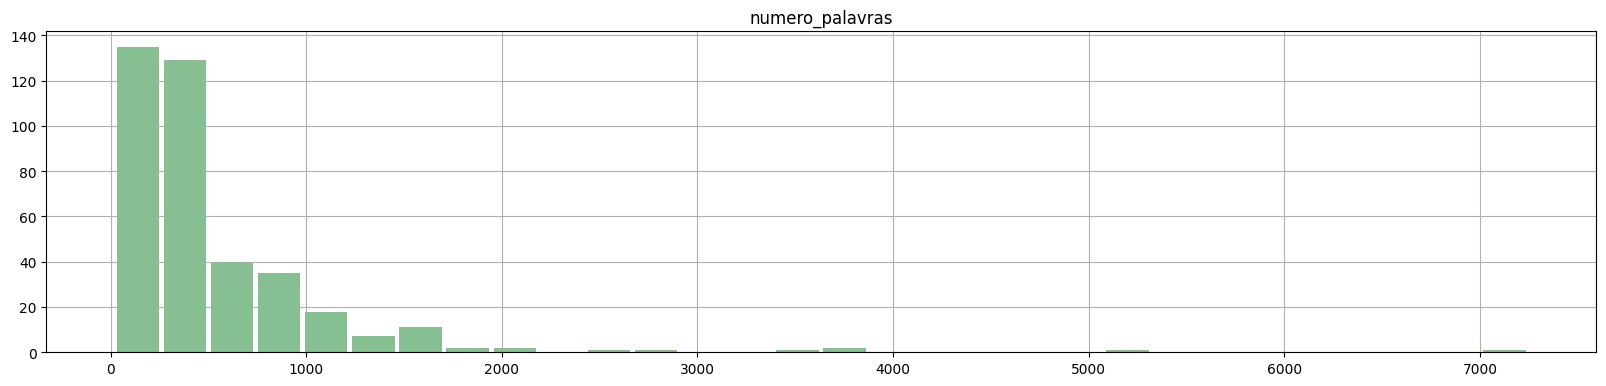

In [15]:
ax = df.hist(column='numero_palavras', bins=30, grid=True, figsize=(20,15), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)


A quantidade de textos com tamanho (`número palavras`) próximo a `512` ou maior é grande. Importante lembrar que temos `wordpieces` então podemos ter textos com `320` a `400` palavras que passem de `512` tokens, já que o tokenizador poderá gerar vários tokens nas palavras que não conhece. 
Como é muito considerável a perda caso utilizassemos o truncamento de tokens caso os textos gerassem mais de `512` tokens então optamos por criar algoritmos que particionam os textos.

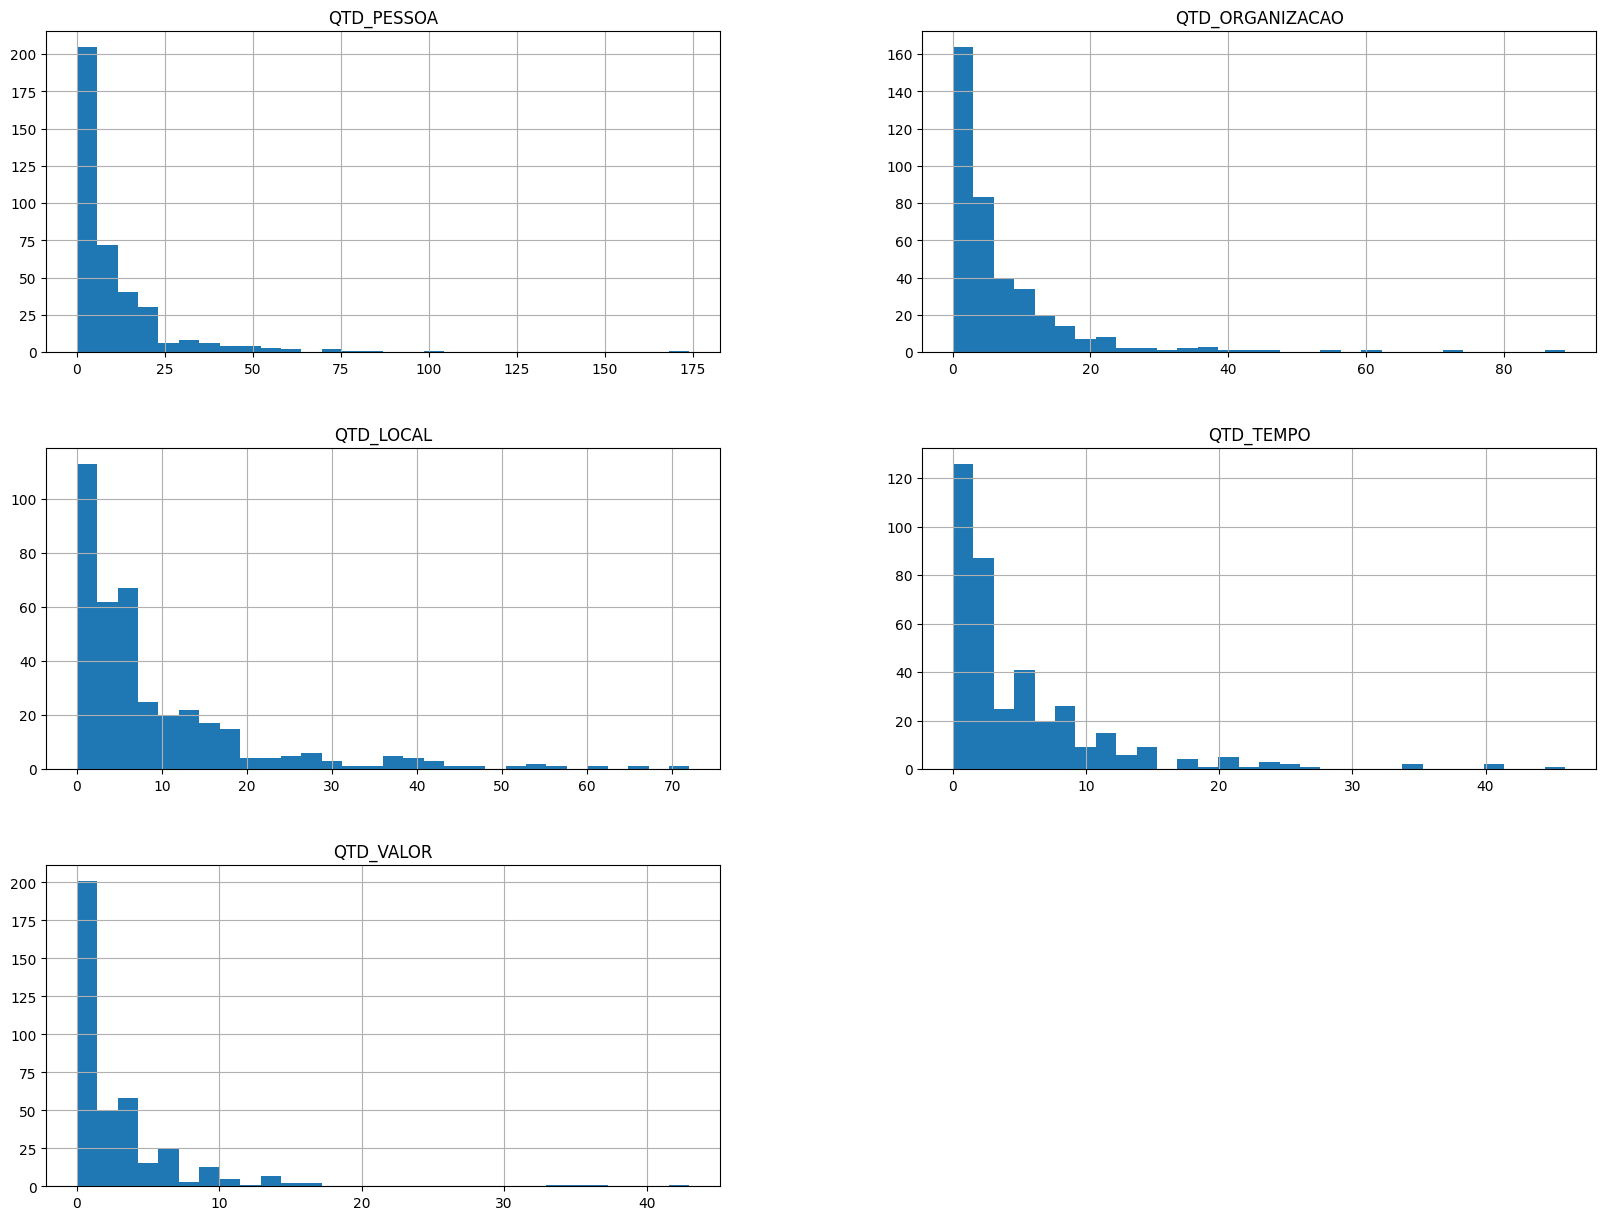

In [16]:
ax = df.hist(column=['QTD_PESSOA','QTD_ORGANIZACAO','QTD_LOCAL', 'QTD_TEMPO', 'QTD_VALOR'], bins=30,
grid=True, figsize=(20, 15))


# Preparação dos Datasets

In [17]:
def align_tokens(batch_encoding :BatchEncoding, 
                list_annotations: List[List[Anotacao]], 
                label_ner: LabelNER) -> TrainingBatchExample:

    """

    Alinhamento dos tokens e respectivos labels para tratar a disparidade gerada pelos Tokenizadores Bert que tratam palavras não encontradas com Worpieces.
    As anotações dos datasets foram criadas levando em conta palavras, mas os tokenizadores incluem partes de palavras (wordpieces), exemplo:
    Starbucks --> Star, ##bu, ##cks. A anotação faz referência a uma entrada B-Location, contudo três entradas deverão ser tratadas após a tokenização.

    Args:
        batch_encoding (BatchEncoding):
            Batch encoding previamente tokenizado (input_ids, attention_mask). 
            Contém lista de Encodings gerados pelo Tokenizador ao fazer a tokenização.
            O modelo é preparado para receber esse tipo de dado, por isso sua estrutura será preservada.
        
        list_annotations(List[List[Anotacao]])
            Lista onde cada entrada contém a lista de anotações de um documento 
        
        label_ner(LabelNER):
            Objeto da classe LabelNER que contém os labels e seus respectivos id's. Será utilizada para converter os labels de string para identificadores.

        Returns:
            TrainingBatchExamples:
                TrainingBatchExamples contendo o BatchEncoding passado e os labels alinhados

    """

    list_aligned_labels: List[List[int]] = []

    for ind_encoding in range(len(batch_encoding.encodings)):
        encoding: Encoding = batch_encoding[ind_encoding]
        annotations = list_annotations[ind_encoding]

        aligned_labels_str: List[str] = align_tokens_from_span_annotations(encoding, annotations)
        
        list_aligned_labels.append(label_ner.convert_label_list_to_id_list(aligned_labels_str))

    training_batch = TrainingBatchExample(batch_encoding, list_aligned_labels)
    
    return training_batch



In [18]:
def align_tokens_from_span_annotations(encoding: Encoding, annotations: List[Anotacao]) -> List[str]:
    """

    Alinhamento das anotações de um documento com as wordpieces.
    
    Args:
        encoding (Encoding):
            Enconding da sentença previamente tokenizada (input_ids, attention_mask)            
        
        annotations(List[Anotacao])
            Lista de spans das entidades. Cada entrada do dicionário contém o label, inicio e fim de uma entidade que pode conter uma ou mais palavras.
            A função espera receber anotações com as seguintes entradas:
                - start - inicio do span
                - end - fim do span
                - label - label do span. Não é esperado que o label contenha os prefixos IOB ou BILOU, somente o nome do label.

        Returns:
            List[str]
                Anotações alinhadas com os tokens

    """

    
    begin_prefix: str='B'
    inside_prefix: str='I'

    tokens = encoding.tokens
    aligned_labels: List[str] = ["O"] * len(tokens)  # Make a list to store our labels the same length as our tokens
    for anno in annotations:
        annotation_token_ix_set = (set())  # A set that stores the token indices of the annotation
        for char_ix in range(anno.start_offset, anno.end_offset):
            token_ix = encoding.char_to_token(char_ix)
            if token_ix is not None:
                if not tokens[token_ix] in PUNCTUATION_LIST: # alguns datasets incluem caracteres de pontuação na entidade por falha nas anotações
                    annotation_token_ix_set.add(token_ix)

        if len(annotation_token_ix_set) == 1:
            # If there is only one token
            token_ix = annotation_token_ix_set.pop()
            aligned_labels[token_ix] = f"{begin_prefix}-{anno.label}"

        else:
            last_token_in_anno_ix = len(annotation_token_ix_set) - 1
            for num, token_ix in enumerate(sorted(annotation_token_ix_set)):                
                if num == 0:
                    prefix = begin_prefix                
                else:
                    prefix = inside_prefix
                aligned_labels[token_ix] = f"{prefix}-{anno.label}"
    return aligned_labels

In [19]:
def prepara_docs_to_bert(doc_list: List[Document], tokenizer:BertTokenizerFast, limite_tokens:int=512) -> List[Document]:
    """
        Tokenização dos documentos e particionamento de um documento em vários, caso necessário, para evitar a perda de dados para treinamento/validação.

        Args:
            doc_list(List[Document]):
                lista de documentos para preparação
            tokenizer(BertTokenizerFast)
                Tokenizador utilizado, vai separar os tokens de acordo com o vocabulário disponível  
            limite_tokens(int)
                Quantidade máxima de tokens por documento

        Returns:
            Lista de documentos com tamanho menor ou igual ao limite de tokens informado. A quantidade de documentos retornados é sempre maior ou igual a quantidade
            informada pelo parametro doc_list

    """

    lista_doc_preparado = []
    for doc in doc_list:
        encoding:Encoding = tokenizer(doc.text)[0]
        if len(encoding.tokens) <= limite_tokens:
            lista_doc_preparado.append(doc)
            continue

        doc_particionado, doc_residual = particiona_doc(doc, encoding, limite_tokens)
        lista_doc_preparado.append(doc_particionado)
        while doc_residual is not None:
            encoding = tokenizer(doc_residual.text)[0]
            doc_particionado, doc_residual = particiona_doc(doc_residual, encoding, limite_tokens)
            lista_doc_preparado.append(doc_particionado)
    
    return lista_doc_preparado

In [20]:
def particiona_doc(doc: Document, encoding: Encoding, limite_tokens) -> Tuple[Document,Document]:
    """ 
        Particiona o documento caso a quantidade de tokens seja maior que o limite, gerando um segundo documento com os tokens que sobraram.        
        A quebra do documento não acontece no limite dos tokens, mas no último separador de sentença disponível ('.', '!' ou '?' )

        Args:
            doc(Document):
                documento que será particionado (caso necessário)
            encoding(Encoding)
                Encoding do documento, contendo os id`s do vocabulário (não será utilizado), tokens e offsets (ambos importantes para a separação)  
            limite_tokens(int)
                Quantidade máxima de tokens por documento            

        Returns: (Document, Document)
            Documento particionado com as anotações preservadas
            Documento residual com as anotações deslocadas

    """

    # Verifica se é necessário particionar
    if len(encoding.tokens) <= limite_tokens:
        return doc, None

    # reservar a posição do [SEP] na tokenização    
    pos_quebra = limite_tokens -1;
    achou_pos_quebra = False
    while not achou_pos_quebra and pos_quebra > 0:
        if encoding.tokens[pos_quebra] in SEPARADOR_SENTENCA:
            achou_pos_quebra = True
        else:
            pos_quebra -= 1


    # Se não encontrar o separadar até o inicio então teremos que separar sentenças no meio
    if not achou_pos_quebra:
        pos_quebra = limite_tokens -1

    # final do token de quebra
    offset_quebra = encoding.offsets[pos_quebra][1]
    offset_inicio_doc_residual = encoding.offsets[pos_quebra+1][0]
    doc_particionado = Document()
    doc_residual = Document()

    doc_particionado.text = doc.text[0:offset_quebra]
    doc_residual.text = doc.text[offset_inicio_doc_residual:]

    for anotacao in doc.lista_anotacao:
        nova_anotacao = Anotacao()
        nova_anotacao.copy_from(anotacao)
        if nova_anotacao.start_offset < offset_quebra:
            doc_particionado.adiciona_anotacao(nova_anotacao)
        else:
            nova_anotacao.start_offset -= offset_inicio_doc_residual
            nova_anotacao.end_offset -= offset_inicio_doc_residual
            doc_residual.adiciona_anotacao(nova_anotacao)


    doc_particionado.conta_palavras()
    doc_residual.conta_palavras()

    return doc_particionado,doc_residual

In [21]:
# separação dos datasets de treino, validação e teste
train_doc_list, test_doc_list = train_test_split(lista_doc_harem, test_size=0.1, random_state=42)
train_doc_list, val_doc_list = train_test_split(train_doc_list, test_size=0.1, random_state=42)


In [22]:
print(len(train_doc_list))
print(len(val_doc_list))
print(len(test_doc_list))


312
35
39


In [23]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)


In [24]:
tokenizer

PreTrainedTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [25]:
# Exemplo comentado para o artigo
#print(lista_doc_harem[0])
#lista = separa_doc_caso_necessario([lista_doc_harem[0]],tokenizer=tokenizer,limite_tokens=100)
#print(lista)
#print(lista[3].text)
#print(lista[3].lista_anotacao)
#lista[3].text[448:466]

In [26]:
train_doc_list = prepara_docs_to_bert(doc_list = train_doc_list, tokenizer=tokenizer, limite_tokens=512)
val_doc_list = prepara_docs_to_bert(doc_list = val_doc_list, tokenizer=tokenizer, limite_tokens=512)


In [27]:
label_ner: LabelNER = LabelNER() 
label_ner.load_from_simple_list(LABEL_LIST)


In [28]:
train_text_list = []
train_annotation_list = []
for doc in train_doc_list:
    train_text_list.append(doc.text)
    train_annotation_list.append(doc.lista_anotacao)

val_text_list = []
val_annotation_list = []
for doc in val_doc_list:
    val_text_list.append(doc.text)
    val_annotation_list.append(doc.lista_anotacao)
    

In [29]:
train_batch_encoding = tokenizer(train_text_list, max_length=512, padding="max_length", truncation=True)
val_batch_encoding = tokenizer(val_text_list, max_length=512, padding="max_length", truncation=True)


In [30]:
train_batch_example:TrainingBatchExample = align_tokens(train_batch_encoding, 
                                                        train_annotation_list,
                                                        label_ner=label_ner)

val_batch_example:TrainingBatchExample = align_tokens(val_batch_encoding, 
                                                    val_annotation_list,
                                                    label_ner=label_ner)

                                                    

In [31]:
indice = 100
print(train_text_list[indice])
print(train_batch_example.batch_encoding.encodings[indice].tokens)
print(train_batch_example.batch_encoding.encodings[indice].offsets)
print(label_ner.convert_id_list_to_label_list(train_batch_example.labels[indice]))



Di Bello Informática... seu Polo de Informática em MADUREIRA- A mais antiga loja de Informática em Madureira, são vinte anos de credibilidade...Hardware, software, suprimentos e manutenção. http://www.webspace.com.br/dibello. Diacon Informática- A Diacon presta serviços de consultoria, treinamento e desenvolvimento de sistemas. http://www.diacon.com.br.
['[CLS]', 'Di', 'Bell', '##o', 'Inf', '##orm', '##ática', '.', '.', '.', 'seu', 'Polo', 'de', 'Inf', '##orm', '##ática', 'em', 'MA', '##D', '##UR', '##EI', '##RA', '-', 'A', 'mais', 'antiga', 'loja', 'de', 'Inf', '##orm', '##ática', 'em', 'Mad', '##ure', '##ira', ',', 'são', 'vinte', 'anos', 'de', 'cred', '##ibilidade', '.', '.', '.', 'Hard', '##ware', ',', 'software', ',', 'suprimentos', 'e', 'manutenção', '.', 'http', ':', '/', '/', 'w', '##ww', '.', 'web', '##s', '##pace', '.', 'com', '.', 'b', '##r', '/', 'di', '##bell', '##o', '.', 'Dia', '##con', 'Inf', '##orm', '##ática', '-', 'A', 'Dia', '##con', 'pres', '##ta', 'serviços', 'de'

# Treinamento

In [32]:
model = BertForTokenClassification.from_pretrained(MODEL_BASE, num_labels=len(label_ner))
model.to('cuda')


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [33]:
for i, w in enumerate(model.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([29794, 768]) True
1 torch.Size([512, 768]) True
2 torch.Size([2, 768]) True
3 torch.Size([768]) True
4 torch.Size([768]) True
5 torch.Size([768, 768]) True
6 torch.Size([768]) True
7 torch.Size([768, 768]) True
8 torch.Size([768]) True
9 torch.Size([768, 768]) True
10 torch.Size([768]) True
11 torch.Size([768, 768]) True
12 torch.Size([768]) True
13 torch.Size([768]) True
14 torch.Size([768]) True
15 torch.Size([3072, 768]) True
16 torch.Size([3072]) True
17 torch.Size([768, 3072]) True
18 torch.Size([768]) True
19 torch.Size([768]) True
20 torch.Size([768]) True
21 torch.Size([768, 768]) True
22 torch.Size([768]) True
23 torch.Size([768, 768]) True
24 torch.Size([768]) True
25 torch.Size([768, 768]) True
26 torch.Size([768]) True
27 torch.Size([768, 768]) True
28 torch.Size([768]) True
29 torch.Size([768]) True
30 torch.Size([768]) True
31 torch.Size([3072, 768]) True
32 torch.Size([3072]) True
33 torch.Size([768, 3072]) True
34 torch.Size([768]) True
35 torch.Size([768]

In [34]:
train_dataset = NERDataset(train_batch_example)
val_dataset = NERDataset(val_batch_example)


In [35]:
training_args = TrainingArguments(
    "results_eddy",          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=20,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True

)



In [36]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_

In [37]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)


In [38]:
trainer.train()

trainer.save_model(MODEL_TRAINED_PATH)
label_ner.save(LABEL_OUTPUT_PATH)


destroy_model(model)
print(get_gpu_memory_status())
destroy_tokenizer(tokenizer)
print(get_gpu_memory_status())

/home/tesla/Eddy_Giusepe_Deep_Learning/NLP_Transformers/venv_transformers/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 618
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 156
  Number of trainable parameters = 108341003
 13%|█▎        | 20/156 [00:10<01:01,  2.21it/s]

{'loss': 1.9957, 'learning_rate': 1e-05, 'epoch': 0.26}


 26%|██▌       | 40/156 [00:19<00:52,  2.20it/s]

{'loss': 0.6698, 'learning_rate': 2e-05, 'epoch': 0.51}


 38%|███▊      | 60/156 [00:28<00:43,  2.22it/s]

{'loss': 0.3962, 'learning_rate': 3e-05, 'epoch': 0.77}


 50%|█████     | 78/156 [00:36<00:28,  2.77it/s]***** Running Evaluation *****
  Num examples = 70
  Batch size = 8
                                                
 50%|█████     | 78/156 [00:37<00:28,  2.77it/s]Saving model checkpoint to results_eddy/checkpoint-78
Configuration saved in results_eddy/checkpoint-78/config.json


{'eval_loss': 0.25317755341529846, 'eval_runtime': 1.5175, 'eval_samples_per_second': 46.128, 'eval_steps_per_second': 5.931, 'epoch': 1.0}


Model weights saved in results_eddy/checkpoint-78/pytorch_model.bin
 51%|█████▏    | 80/156 [00:40<01:17,  1.03s/it]

{'loss': 0.2427, 'learning_rate': 4e-05, 'epoch': 1.03}


 64%|██████▍   | 100/156 [00:49<00:25,  2.20it/s]

{'loss': 0.1557, 'learning_rate': 5e-05, 'epoch': 1.28}


 77%|███████▋  | 120/156 [00:58<00:16,  2.19it/s]

{'loss': 0.1196, 'learning_rate': 3.2142857142857144e-05, 'epoch': 1.54}


 90%|████████▉ | 140/156 [01:07<00:07,  2.19it/s]

{'loss': 0.1023, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.79}


100%|██████████| 156/156 [01:14<00:00,  2.76it/s]***** Running Evaluation *****
  Num examples = 70
  Batch size = 8
                                                 
100%|██████████| 156/156 [01:15<00:00,  2.76it/s]Saving model checkpoint to results_eddy/checkpoint-156
Configuration saved in results_eddy/checkpoint-156/config.json


{'eval_loss': 0.11247727274894714, 'eval_runtime': 1.5315, 'eval_samples_per_second': 45.707, 'eval_steps_per_second': 5.877, 'epoch': 2.0}


Model weights saved in results_eddy/checkpoint-156/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results_eddy/checkpoint-156 (score: 0.11247727274894714).
100%|██████████| 156/156 [01:17<00:00,  2.01it/s]
Saving model checkpoint to /home/tesla/Eddy_Giusepe_Deep_Learning/NLP_Transformers/NER_BERT_Deep_Learning/Dataset_HAREM_processamento/dataset/portuguese-ner
Configuration saved in /home/tesla/Eddy_Giusepe_Deep_Learning/NLP_Transformers/NER_BERT_Deep_Learning/Dataset_HAREM_processamento/dataset/portuguese-ner/config.json


{'train_runtime': 77.5655, 'train_samples_per_second': 15.935, 'train_steps_per_second': 2.011, 'train_loss': 0.48031712953860944, 'epoch': 2.0}


Model weights saved in /home/tesla/Eddy_Giusepe_Deep_Learning/NLP_Transformers/NER_BERT_Deep_Learning/Dataset_HAREM_processamento/dataset/portuguese-ner/pytorch_model.bin


Total: 12193.06 | Reserved: 1804.00 | Allocated: 1718.62
Total: 12193.06 | Reserved: 1804.00 | Allocated: 1718.62


In [ ]:
%load_ext tensorboard

%tensorboard --logdir /eddy_adicionar_path

In [ ]:
# Grafico sobre train e evaluation loss
df = pd.read_csv(MODEL_TRAINED_LOG, sep='\t')
df['Epoch'] = round((df.Step * training_args.per_device_train_batch_size) / len(train_dataset), 2)
df.tail(10)

train_loss = df[['Epoch', 'Training Loss']].to_numpy()
validation_loss = df[['Epoch', 'Validation Loss']].to_numpy()

plot_grafico_trainer_loss(train_loss, validation_loss)